In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../..')
from hamp_pred.src.input_prep.prepare_sequence import MultiChainOperator, SeqWindow
from hamp_pred.src.input_prep.encode import MultiEncoder, OneHotEncoderSeq, RadianEncoder 
from hamp_pred.src.input_prep.encode import RadiousPhobosEncoder
from hamp_pred.src.predictor_config import PredictionConfig 
from hamp_pred.src.models.common.models import BaseConvolutionalWrapper 
from hamp_pred.src.predictor import Predictor

## Prepare data

In [2]:
DATA_DIR = '../../data/input'

# data set contains train and validation sets
# the val set is used for eraly stopping 
data = f'{DATA_DIR}/af2_all_params.p'
data = pd.read_pickle(data)

data['train_seq'] = data.apply(lambda x: x['n_seq'] + x['c_seq'], axis=1)


assert all(data['train_seq'].str.len() == 22)

# separate test set used to pick the best model
#data_test = f'{DATA_DIR}/af_clean_model_test.p'
#data_test = pd.read_pickle(data_test)

In [3]:
data['class'].value_counts()

train    3978
val       994
Name: class, dtype: int64

## Train and validate

In [4]:
def get_rmse(val, mod):
    params_rmse = {"rot":0, "shift_diff":0, "radius_diff":0}
    tr_d = {"rot":0, "shift_diff":0, "radius_diff":0}
    pr_d = {"rot":0, "shift_diff":0, "radius_diff":0}
    seqs = list(val.train_seq)
    tr=[]
    for key in params_rmse:
        for n,r in val.iterrows():
            tr.append(np.mean((r[key][0::2] + r[key][1::2]) / 2)/2)
            tr_d[key] = tr
    res = mod.predict(seqs)
    pr = []
    size=1
    for key in params_rmse:
        for n,r in res.iterrows():
            pr.append(np.mean(r['predicted_params'])/2)
            pr_d[key] = pr
    for key in params_rmse:
        params_rmse[key] = np.mean((np.array(tr_d[key])-np.array(pr_d[key])) **2 ) ** 0.5
    return params_rmse

In [5]:
def train(data, conf, version):
    operator = MultiChainOperator(MultiEncoder([RadiousPhobosEncoder(), OneHotEncoderSeq()]), SeqWindow(11, 11), RadianEncoder(100),  SeqWindow(11, 11, null_char=[[0]]),
                                          parallel=True)
    conf = PredictionConfig(BaseConvolutionalWrapper, operator, conf)
    mod = Predictor('hamp_full_params', config=conf, version=version)
    trained = mod.train(data)
    return mod, trained

def get_mod(conf=None, version=None):
    operator = MultiChainOperator(MultiEncoder([RadiousPhobosEncoder(), OneHotEncoderSeq()]), SeqWindow(11, 11), RadianEncoder(100),  SeqWindow(11, 11, null_char=[[0]]),
                                          parallel=True)
    conf = PredictionConfig(BaseConvolutionalWrapper, operator, conf)
    mod = Predictor('hamp_full_params', config=conf, version=version)
    return mod
    

In [6]:
def opt_conf(data, tune=False):
    
    # data: train and val (val for the eraly stopping)
    
    data_val = data[data['class'] == 'val']
    
    results = {}

    # parameters grid
    kernels = [(3, 4, 7)]
    layers = [3]
    lstm = [1, 2]
    dense = [1, 3]
    
    for kern in kernels:
        for l in layers:
            for ls in lstm:
                for d in dense:
                    model_config = {
                        'activation': 'tanh',
                        'norm': True,
                        'n_layers': l,
                        'kernel_sizes': kern,
                        'lstm': ls,
                        'dense': d,
                        'reshape_out': False,
                        'epochs': 100
                    }
                    version = '_'.join([str(x) for x in ["_".join([str(i) for i in kern]), l, ls, d]])
                    if tune:
                        mod, trained = train(data, model_config, version)
                    else:
                        mod = get_mod(model_config, version)
                        
                    results[version] = (get_rmse(data_val, mod), model_config)
    return results
        

## Tune hiperparameters

In [7]:
# uncomment me 
# opt_res = opt_conf(data, tune=True)  
np.max(np.concatenate(data['radius_diff'].values))

10.617227642738216

In [8]:
# def get_seqs_vals(data, operator):
#     if 'train_seq' not in data.columns:
#         data['train_seq'] = data.apply(lambda x: x['n_seq'] + x['c_seq'], axis=1)
#     params = ["rot", "shift_diff", "radius_diff"]
#     seqs = list(data.train_seq.values)
#     results = []
#     for ind, row in data.iterrows():
#         r = {param: list((row[param][0::2] + row[param][1::2]) / 2) for param in params}
#         res = [list(zip(*list(r.values()))), list(zip(*list(r.values())))]
#         results.append(res)
#     train, valid, test = operator.get_for_train(seqs, results, test_size=0, valid_size=0)
#     return results
# get_seqs_vals(data, None)

In [9]:
# kern, layers, lstm, dense
for pos, (k, (v, model_config)) in enumerate(sorted(opt_res.items(), key=lambda item: item[1])):
    if pos==0:
        best_model_config = model_config
        best_file = k
        
    print(pos+1, k, round(v, 2))

NameError: name 'opt_res' is not defined

In [10]:
best_model_config

NameError: name 'best_model_config' is not defined

## Best Config

In [11]:
best_model_config = {'activation': 'tanh',
 'norm': True,
 'n_layers': 3,
 'kernel_sizes': (3, 4, 7),
 'lstm': 2,
 'dense': 1,
 'reshape_out': False,
 'epochs': 100,
 'task': 'hamp_rot',
 'version': None,
 'data_dir': '/home/users/sdunin/calc/HAMPpred/data/output/weights/hamp_rot/3_4_7_3_2_1'}

best_file = None

In [12]:
data.iloc[0]["shift_diff"]

array([1.28233791, 1.29882653, 1.27105743, 1.3027299 , 1.25885911,
       1.30058658, 1.20543679, 1.21997438, 1.22522848, 1.27387911,
       1.19880911, 1.06475964, 1.32753364, 1.17152734, 0.91577801,
       1.29810288, 1.24977264, 1.07383172, 1.19186641, 1.08857211,
       1.12753206, 1.16927619])

In [13]:
mod = get_mod(conf=best_model_config, version=None)
resmod.predict(list(data.train_seq.values))

2023-09-15 20:19:42.577562: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


5/5 [==============================] - 2s 191ms/step


,id,external_id,sequence,N,C,lengths,linkers,N_pred,C_pred,predicted_params
0,0,None,LKELVQGVQRIIGELITSFNLM,LKELVQGVQRI,IGELITSFNLM,"[11, 11]",[0],"[[-4.068075180053711, 0.642819344997406, 0.017...","[[-4.068075180053711, 0.642819344997406, 0.017...","[[-4.068075180053711, 0.642819344997406, 0.017..."
1,1,None,IRELVEGVRSILGELIASFNDM,IRELVEGVRSI,LGELIASFNDM,"[11, 11]",[0],"[[3.763925552368164, 0.8194202184677124, -0.38...","[[3.763925552368164, 0.8194202184677124, -0.38...","[[3.763925552368164, 0.8194202184677124, -0.38..."
2,2,None,IKELLDGVKNILGELIVNFNEM,IKELLDGVKNI,LGELIVNFNEM,"[11, 11]",[0],"[[14.137857437133789, 0.9143211841583252, -0.1...","[[14.137857437133789, 0.9143211841583252, -0.1...","[[14.137857437133789, 0.9143211841583252, -0.1..."
3,3,None,LSELRKGIRRVLGDLILQFNDM,LSELRKGIRRV,LGDLILQFNDM,"[11, 11]",[0],"[[6.561121940612793, 1.4681501388549805, 0.271...","[[6.561121940612793, 1.4681501388549805, 0.271...","[[6.561121940612793, 1.4681501388549805, 0.271..."
4,4,None,VKELLRGVRAVLGELVNGFNDM,VKELLRGVRAV,LGELVNGFNDM,"[11, 11]",[0],"[[4.83780574798584, 1.020297646522522, 0.52245...","[[4.83780574798584, 1.020297646522522, 0.52245...","[[4.83780574798584, 1.020297646522522, 0.52245..."
...,...,...,...,...,...,...,...,...,...,...
4967,4967,None,IAVLKSHLSQLAGRLIPDIKRL,IAVLKSHLSQL,AGRLIPDIKRL,"[11, 11]",[0],"[[-11.423006057739258, -0.3406451344490051, 1....","[[-11.423006057739258, -0.3406451344490051, 1....","[[-11.423006057739258, -0.3406451344490051, 1...."
4968,4968,None,LQKIEWMTEKIIKKILETFGRM,LQKIEWMTEKI,IKKILETFGRM,"[11, 11]",[0],"[[-0.9676144123077393, 0.3188813328742981, 0.1...","[[-0.9676144123077393, 0.3188813328742981, 0.1...","[[-0.9676144123077393, 0.3188813328742981, 0.1..."
4969,4969,None,IRQLERRIFSLLVSLGERLTWL,IRQLERRIFSL,LVSLGERLTWL,"[11, 11]",[0],"[[-1.2467646598815918, 0.5369485020637512, -0....","[[-1.2467646598815918, 0.5369485020637512, -0....","[[-1.2467646598815918, 0.5369485020637512, -0...."
4970,4970,None,VKLLENRIHHIFLTINQRLDWL,VKLLENRIHHI,FLTINQRLDWL,"[11, 11]",[0],"[[5.897941589355469, 0.6094955801963806, -0.38...","[[5.897941589355469, 0.6094955801963806, -0.38...","[[5.897941589355469, 0.6094955801963806, -0.38..."


# PDB set performance

In [14]:
test_data = pd.read_pickle(f'{DATA_DIR}/pdb_measure.p')

In [15]:
test_data = pd.read_pickle(os.path.join(DATA_DIR, 'pdb_measure.p'))
test_data = test_data[~test_data.mutant]
test_data.rename(columns={'seq1':'n_seq', 'seq2':'c_seq', 'n_list':'n_crick_mut', 'c_list':'c_crick_mut'}, inplace=True)
test_data['n_seq'] = test_data['n_seq'].apply(lambda x: x[1:-1])
test_data['c_seq'] = test_data['c_seq'].apply(lambda x: x[1:-1])
test_data['train_seq'] = test_data.apply(lambda x: x['n_seq'] + x['c_seq'], axis=1)
len(test_data)

11

In [17]:
seq = []
tr = []
for n,r in test_data.iterrows():
    seq.append(r['n_seq'] + r['c_seq'])
    tr.append(np.mean((r['rot'][0::2] + r['rot'][1::2]) / 2)/2)
res = mod.predict(seq)
pr = []
for n,r in res.iterrows():
    pr.append(np.mean(r['predicted_params'][0])/2)

1/1 [==============================] - 1s 1s/step


Text(0.5, 1.0, 'HAMPpred predictions')

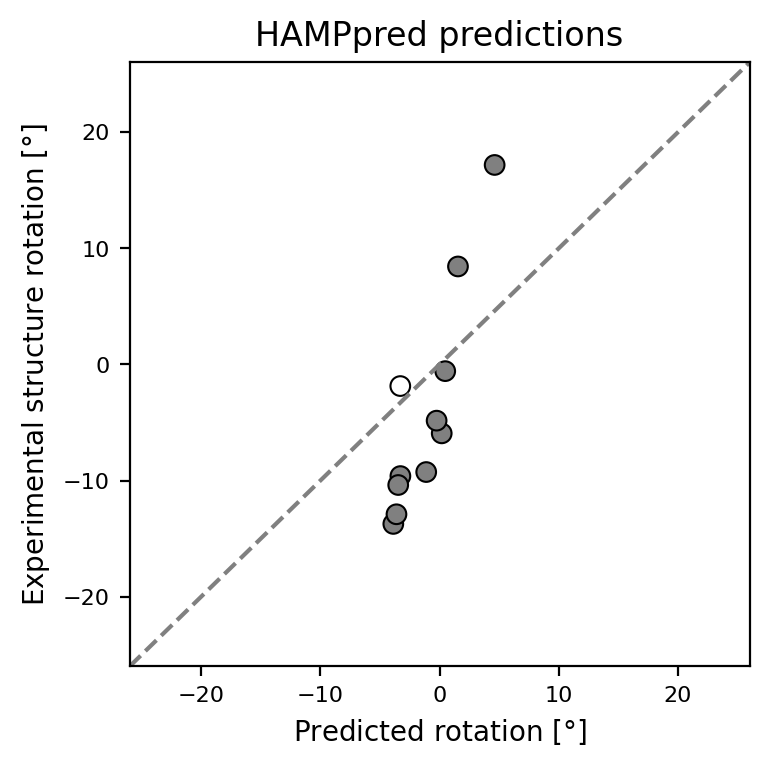

In [18]:
title_font_size = 12
label_font_size = 10
tick_font_size = 8

fig, ax = plt.subplots(1,1, figsize=(4, 4), dpi=200)

colors = ['white' if i=='1_2l7i.pdb' else 'grey' for i in test_data.index]

ax.scatter(pr, tr, color=colors, lw=0.75, edgecolors='k', s=50)

ax.set_ylim(-26, 26)
ax.set_xlim(-26, 26)
ax.plot([0, 1], [0, 1], '--', transform=ax.transAxes, color='grey')

ax.set_xlabel(r'Predicted rotation [$\degree$]', size=label_font_size)
ax.set_ylabel(r'Experimental structure rotation [$\degree$]', size=label_font_size)

ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
ax.tick_params(axis='both', which='minor', labelsize=tick_font_size)
ax.set_title("HAMPpred predictions", size=title_font_size)

In [30]:
np.mean((np.asarray(tr)-np.asarray(pr)) **2 ) ** 0.5

4.75618170787087

In [ ]:
# Done!

In [33]:
res.iloc[0].N_pred.shape

(11, 1)